In [1]:
# Import libraries
import os
import cv2
import imghdr
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt

from utils.graph import *
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D

/tmp/ipykernel_99468/2769480625.py:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr
2023-11-07 15:26:40.170909: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-07 15:26:40.172653: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-07 15:26:40.198521: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-07 15:26:40.198553: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-07 1

In [2]:
# Set directories
root_dir = os.getcwd()
data_dir = os.path.join(root_dir, 'mosquitoes-dataset')
test_dir = os.path.join(root_dir, "test-dataset")

In [3]:
tf.random.set_seed(1234)
random.seed(1234)
np.random.seed(1234)

# Preprocessing

In [4]:
IMG_DIM = 224
IMG_SIZE = (IMG_DIM, IMG_DIM)
IMG_SHAPE = IMG_SIZE + (3,)
image_ext = ['jpeg', 'jpg', 'png']

In [5]:
class_names = os.listdir(data_dir)

In [6]:
# Remove corrupted images
for label in class_names:
    for image in os.listdir(os.path.join(data_dir, label)):
        image_path = os.path.join(data_dir, label, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_ext:
                print('Image not in extensions list {}' .format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}' .format(image_path))
            os.remove(image_path)

In [7]:
# Resize and normalize
resize_and_normalize = tf.keras.Sequential([tf.keras.layers.Resizing(IMG_DIM, IMG_DIM),
                                            tf.keras.layers.Rescaling(1./255),
                                            ])

In [8]:
# Data augmentation
data_augment = tf.keras.Sequential([tf.keras.layers.RandomFlip('horizontal_and_vertical'),
                                    tf.keras.layers.RandomRotation(0.2),
                                    tf.keras.layers.RandomContrast(0.2),
                                    ])

In [9]:
# Data preparation wrapper
AUTOTUNE = tf.data.AUTOTUNE


def prepare(ds, augment=False):
    ds = ds.map(lambda x, y: (resize_and_normalize(x), y),
                num_parallel_calls=AUTOTUNE)

    if augment:
        ds = ds.map(lambda x, y: (data_augment(x), y),
                    num_parallel_calls=AUTOTUNE)

    ds.cache()
    ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# Create dataset

In [10]:
# Load data using Keras
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                               image_size=IMG_SIZE,
                                                               seed=1234,
                                                               batch_size=32,
                                                               validation_split=0.2,
                                                               subset='both',
                                                               )

Found 1000 files belonging to 2 classes.
Using 800 files for training.
Using 200 files for validation.


In [11]:
train_ds = prepare(train_ds, augment=True)
val_ds = prepare(val_ds)

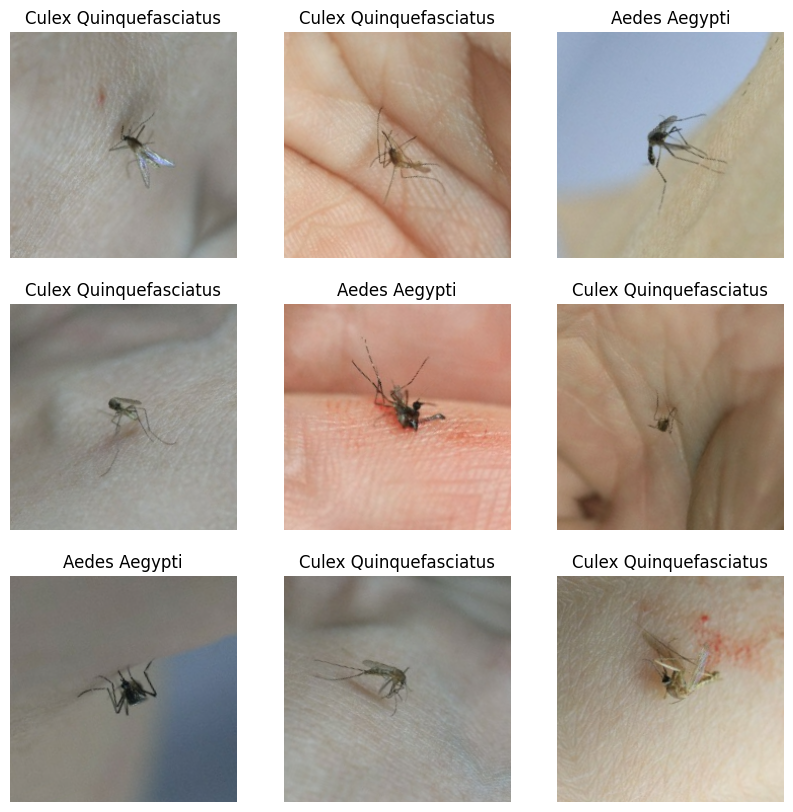

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])
        plt.axis('off')

# Build model

In [13]:
model = Sequential()

In [14]:
model.add(InputLayer(input_shape=IMG_SHAPE))

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())
model.add(Dense(2, activation='softmax'))

In [15]:
base_learning_rate = 1e-4
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              )

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)       

# Train model

In [17]:
history = model.fit(train_ds,
                    epochs=30,
                    validation_data=val_ds,
                    )

Epoch 1/30
25/25 [==============================] - 7s 223ms/step - loss: 0.6972 - accuracy: 0.4988 - val_loss: 0.6929 - val_accuracy: 0.5000
Epoch 2/30
25/25 [==============================] - 6s 231ms/step - loss: 0.6930 - accuracy: 0.5138 - val_loss: 0.6928 - val_accuracy: 0.5050
Epoch 3/30
25/25 [==============================] - 8s 290ms/step - loss: 0.6930 - accuracy: 0.5088 - val_loss: 0.6928 - val_accuracy: 0.5050
Epoch 4/30
25/25 [==============================] - 7s 279ms/step - loss: 0.6935 - accuracy: 0.4963 - val_loss: 0.6927 - val_accuracy: 0.5000
Epoch 5/30
25/25 [==============================] - 7s 265ms/step - loss: 0.6932 - accuracy: 0.5013 - val_loss: 0.6927 - val_accuracy: 0.5250
Epoch 6/30
25/25 [==============================] - 8s 290ms/step - loss: 0.6927 - accuracy: 0.5063 - val_loss: 0.6925 - val_accuracy: 0.5050
Epoch 7/30
25/25 [==============================] - 7s 275ms/step - loss: 0.6939 - accuracy: 0.4925 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 

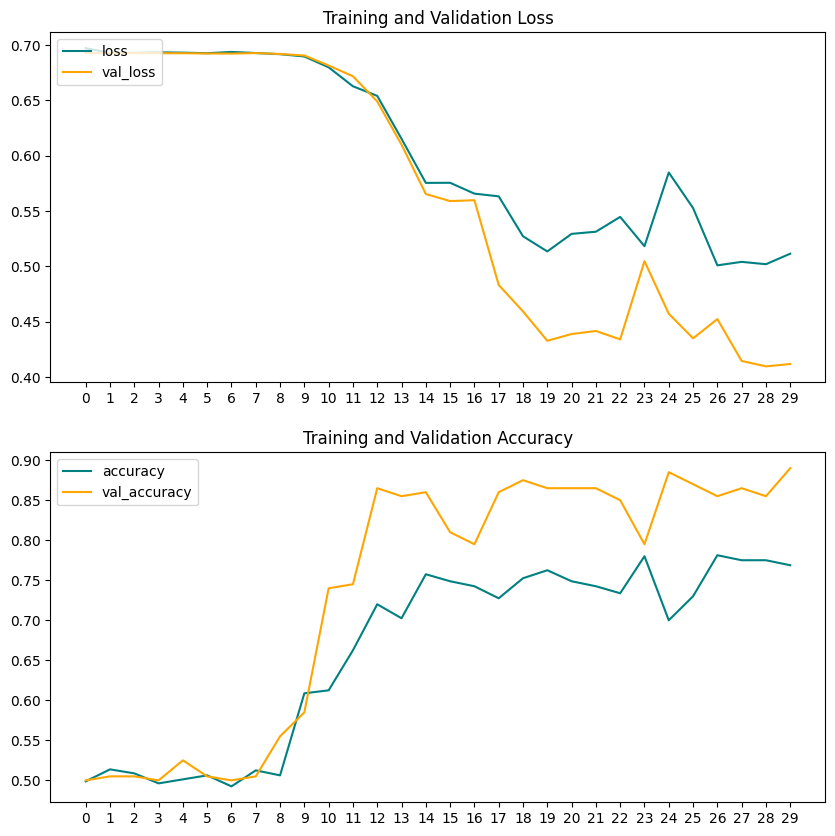

In [18]:
draw_learning_curve(history)

# Evaluation

In [19]:
test_ds_count = 0
for r, d, f in os.walk(test_dir):
    test_ds_count += len(f)

In [20]:
test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                      seed=1234,
                                                      image_size=IMG_SIZE,
                                                      batch_size=test_ds_count,
                                                      )

Found 193 files belonging to 2 classes.


In [21]:
test_ds = prepare(test_ds)

In [22]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
yhat = model.predict_on_batch(image_batch)

yhat = tf.nn.softmax(yhat)

label_yhat = np.empty(0, dtype=int)
for i in range(test_ds_count):
    label_yhat= np.append(label_yhat, np.argmax(yhat[i]))

# print('Predictions:\n', yhat.numpy())
print('True labels:\n', label_batch)
print('Predicted labels:\n', label_yhat)

True labels:
 [0 0 1 1 0 1 1 0 0 0 0 0 1 1 0 1 1 1 0 0 1 0 1 1 1 0 0 0 0 0 1 1 0 0 1 0 0
 1 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 1 1 0 0 1 0 1 0 1 0 0 1 0 1 1
 1 1 0 1 0 0 1 1 0 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 1
 0 0 1 0 0 1 0 1 1 0 1 0 1 1 1 0 1 1 0 1 0 1 1 0 0 1 0 1 1 1 0 1 0 0 0 1 0
 0 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0 1
 1 1 1 1 0 0 1 1]
Predicted labels:
 [0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 1 0 0
 1 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 1 1 0 0 1 0 1 0 1 0 0 1 0 1 1
 1 1 0 1 0 0 1 1 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 1 0 0 0 1
 0 0 1 0 0 1 0 1 1 0 1 0 1 1 1 0 1 1 0 1 0 0 1 0 0 1 0 1 1 1 0 1 0 0 0 1 0
 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 1 1 1 0 1 0 1
 1 0 1 1 0 0 1 1]


In [23]:
cm = confusion_matrix(label_batch, label_yhat)
print(cm)

[[102   0]
 [ 13  78]]


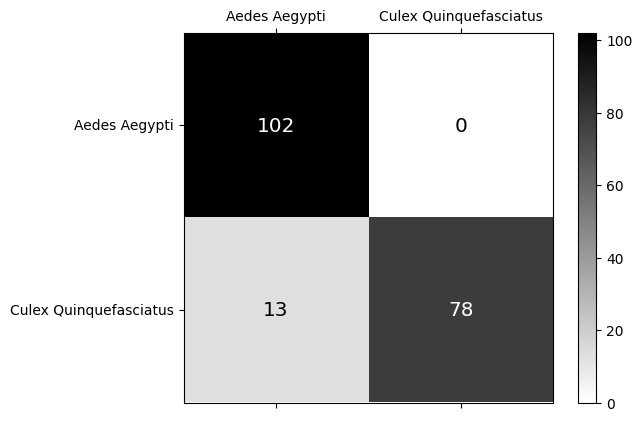

In [24]:
draw_confusion_matrix(cm, class_names)

In [25]:
# cm_disp = ConfusionMatrixDisplay.from_predictions(y_true=label_batch,
#                                                   y_pred=label_yhat,
#                                                   display_labels=class_names,
#                                                   cmap=plt.cm.gray_r,
#                                                   )

In [26]:
# plt.figure(figsize=(20, 20))
# for i in range(35):
#     plt.subplot(10, 5, i + 1)
#     plt.imshow(image_batch[i].astype('uint8'))
#     plt.title(class_names[np.argmax(yhat[i])])
#     plt.axis('off')

In [27]:
model.save(os.path.join(root_dir, 'models', 'mosquitoes_model.keras'))